In [3]:
import numpy as np
import matplotlib.pyplot as plt
import simpy #pip install if needed?

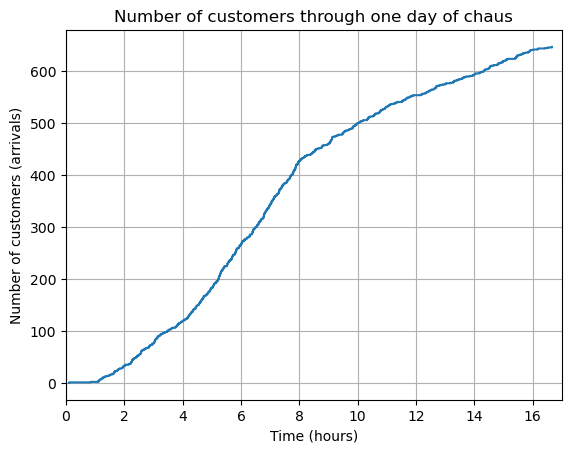

Results without antithetic variables:
Mean of average number of customers in a day: 621.51
Mean of median time a customer goes to chaus: 6.638309217749453
Variance of this median list: 0.026433455759947152
95% CI of total number of arrivals in a day: (621.4667818412069, 624.5612181587932)
 
Results with antithetic variables:
Mean of average number of customers in a day: 623.28
Mean of median time a customer goes to chaus: 6.636663398603977
Variance of this median list: 0.01374022534969723


In [390]:
def gen_rate(time):
    """
    Piece-wise intensity helper function for arrival rates in the coffee shop
    simulating a non-homogenous poisson process.
    
    Input: 
    - time: hour for which store is open (integer in [0, 17])
    
    Returns the arrival rate for the specific time input.
    """
    if time >= 0 and time <= 1: # 7 am - 8 am
        rate = 19
    if time > 1 and time <= 2: # 8 am - 9 am
        rate = 49
    if time > 2 and time <= 3: # 9 am - 10 am
        rate = 65
    if time > 3 and time <= 4: # 10 am - 11 am
        rate = 56
    if time > 4 and time <= 5: # 11 am - 12 pm
        rate = 65
    if time > 5 and time <= 6: # 12 pm - 1 pm
        rate = 77
    if time > 6 and time <= 7: # 1 pm - 2 pm
        rate = 77
    if time > 7 and time <= 8: # 2 pm - 3 pm
        rate = 77
    if time > 8 and time <= 9: # 3 pm - 4 pm
        rate = 49
    if time > 9 and time <= 10: # 4 pm - 5 pm
        rate = 51
    if time > 10 and time <= 11: # 5 pm - 6 pm
        rate = 49
    if time > 11 and time <= 12: # 6 pm - 7 pm 
        rate = 40
    if time > 12 and time <= 13: # 7 pm - 8 pm
        rate = 35
    if time > 13 and time <= 14: # 8 pm - 9 pm
        rate = 40
    if time > 14 and time <= 15: # 9 pm - 10 pm
        rate = 44
    if time > 15 and time <= 16: # 10 pm - 11 pm
        rate = 40
    if time > 16 and time <= 17: # 11 pm - 12 am
        rate = 23
    return rate

def gen_arrivals(max_t):
    """
    Using thinning method to generate arrival times for the non-homogenous 
    poisson process.
    
    Input:
    - max_t: the number of hours we want to generate arrivals until. 
            In this case, it is the number of hours before Chaüs closes after one day.
    """
   
    # Initializing variables
    time, arrival_times, opt_rate = 0, [], 77

    while time < max_t:

        # generating variables and updating event time
        U1 = np.random.uniform(0, 1)
        time = time - (np.log(U1)) / (gen_rate(time))
   
        # edge case where we run one more iteration
        if time > max_t: 
            break
          
        # accepting arrival_times if condition is met
        U2 = np.random.uniform(0, 1)

        # performing thinning with optimal rate (upper bound of 77)
        if U2 <= (gen_rate(time)) / (opt_rate):
            arrival_times.append(time)
            
    return arrival_times

#plotting
arrivals = gen_arrivals(17)
plt.step(arrivals, range(len(arrivals)), where='post')
plt.xlabel('Time (hours)')
plt.ylabel('Number of customers (arrivals)')
plt.xlim(0, 17)        
plt.title('Number of customers through one day of chaus')
plt.grid(True)
plt.show()

#getting mean over 1000 runs
res, med = [], []
for path in range(1000):
    result = gen_arrivals(17)
    res.append(len(result)) #gets this many arrivals at the end of a day
    med.append(np.median(result)) #gets time where the average person goes

print("Results without antithetic variables:")
print("Mean of average number of customers in a day: " + str(np.mean(res)))
print("Mean of median time a customer goes to chaus: " + str(np.mean(med)))
print("Variance of this median list: " + str(np.var(med)))

def confidence_interval(n):
    """
    Calculates a 95% confidence interval for our results over n trials.
    """
    res = []
    for path in range(n):
        result = gen_arrivals(17)
        res.append(len(result)) 
    
    # getting mean of average wait time of one day across n trials
    mean = np.mean(res) 
    sem = stats.sem(res) # standard error of mean
    confidence_level = 0.95

    # creating confidence interval
    error = sem * stats.t.ppf((1 + confidence_level) / 2, len(res) - 1) 
    CI = (mean - error, mean + error)
    
    return CI

CI = confidence_interval(1000)
print("95% CI of total number of arrivals in a day: " + str(CI))



def antithetic():
    """
    Generates a list of uniform random variables
    that are negatively correlated to the next one on the list.
    """
    U_lst = []
    for i in range(1000):
        U = np.random.uniform(0, 1)
        anti_U = 1 - U
        U_lst.append(U)
        U_lst.append(anti_U)
    return U_lst

def gen_arrivals_antithetic(max_t):
    """
    Using thinning method with antithetic variables to generate arrival times 
    for the non-homogenous poisson process.
    
    Input:
    - max_t: the number of hours we want to generate arrivals until. 
            In this case, it is the number of hours before Chaüs closes after one day.
    """
   
    # Initializing variables
    time, arrival_times, opt_rate = 0, [], 77
    U_lst = antithetic()
    idx = 0
    while time < max_t:

        # updating time by using antithetic rvs
        time = time - (np.log(U_lst[idx])) / (gen_rate(time))

        # edge case where we run one more iteration
        if time > max_t: 
            break
        
        
        # Accepting arrival_times if condition is met with antithetic variable
        U2 = np.random.uniform(0, 1)

        # Performing thinning with optimal rate (upper bound of 77)
        if U2 <= (gen_rate(time)) / (opt_rate):
            arrival_times.append(time)
        idx += 1
        
    return arrival_times

print(" ")
print("Results with antithetic variables:")
#getting mean over 1000 runs for ANTITHETIC
res, med = [], []
for path in range(1000):
    result = gen_arrivals_antithetic(17)
    res.append(len(result))
    med.append(np.median(result)) #gets time where the average person goes

print("Mean of average number of customers in a day: " + str(np.mean(res)))
print("Mean of median time a customer goes to chaus: " + str(np.mean(med)))
print("Variance of this median list: " + str(np.var(med)))


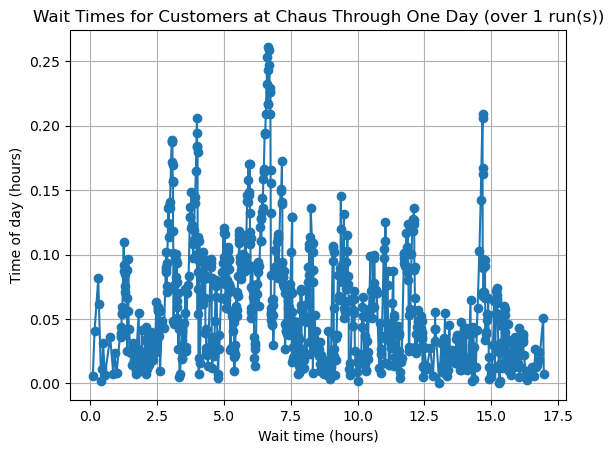

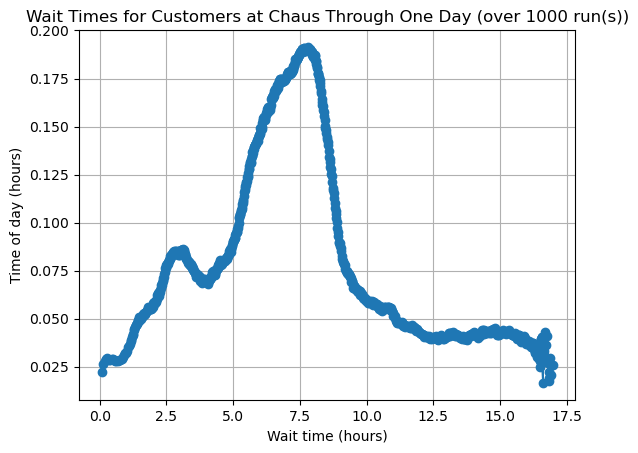

Expected wait of a customer at any point of the day is 0.08802833434015728 hours.
Variance of this is 0.0008487564081912085
MSE of estimator = 1.1181080452913389e-06
95% Confidence interval = (0.0874876974578432, 0.09114389736404686)


In [383]:
import simpy
import numpy as np
from scipy.stats import norm
from scipy import stats

def run():
    """
    Runs one simulation of a day at Chaüs.
    
    Returns a list of waiting times, where each entry i is how long customer i
    has spent in the coffee shop. Also returns a list of times, representing how far
    along the day it is from 0 hr to 17 hr (representing 7 am open and 12 am close).
    """

    # setting up simulation environment and the queues
    env = simpy.Environment()
    order_queue = simpy.Resource(env) #, capacity=1)
    drink_queue = simpy.Resource(env) #, capacity=1)

    # to store our results
    wait_time, time_lst = [], []

    def customer(env, name, order_queue, drink_queue, order_mu, drink_mu_slow, drink_mu_fast):
        """
        Models two M/M/1 queues in tandem. The first queue is for a customer 
        to order their drink. The second queue is for a customer to wait for their drink.
        
        We add the final exit time, along with the current time in the day, to our lists.
        """

        # Customer arrives and joins the first queue
        arrival_time = env.now

        # customer is in cashier queue
        with order_queue.request() as request:
            yield request
            order_enter_time = env.now
            order_service_time = np.random.exponential(1 / order_mu)
            yield env.timeout(order_service_time)
            order_exit_time = env.now
        
        # if customer orders a drink
        if np.random.uniform(0, 1) <= 0.95:
            # customer is in drink queue
            with drink_queue.request() as request:
                yield request
                drink_enter_time = env.now

                # generating service times for drinks depending on type of drink (slow/fast)
                speed = np.random.uniform(0, 1)
                if speed <= 0.50: 
                    U1 = np.random.uniform(0, 1)
                    drink_service_time = -np.log(U1) / drink_mu_slow
                    
                else:
                    U2 = np.random.uniform(0, 1)
                    drink_service_time = -np.log(U2) / drink_mu_fast
                yield env.timeout(drink_service_time)
                drink_exit_time = env.now
            # time customer spent in the system (both queues)
            system_time = drink_exit_time - arrival_time
            wait_time.append(system_time)
            time_lst.append(drink_exit_time)
        
        # if customer doesn't order a drink
        else:
            system_time = order_exit_time - arrival_time
            wait_time.append(system_time)
            time_lst.append(order_exit_time)


    def customer_arrival_process(env, order_queue, drink_queue):
        """
        Makes sure customers arrive according to a non-homogenous poisson process defined in
        gen_rate(time) function. With correct arrival times, we can run the tandem queues
        above. 
        """
        customer_num = 0
        while True:
            interarrival_time = np.random.exponential(1 / gen_rate(env.now))
            yield env.timeout(interarrival_time)
            env.process(customer(env, customer_num, order_queue, drink_queue, 81, 70, 150)) #slow, fast
            customer_num += 1

    # Run the simulation for 17 hours (one work day)
    env.process(customer_arrival_process(env, order_queue, drink_queue))
    env.run(until = 17) 
    return wait_time, time_lst


def run_plot(paths):
    """
    Runs the simulation "paths" number of times and creates a plot 
    looking at the average wait time of a customer throughout the day.
    
    """
    # Lists to store results for each run
    big_wait_times = []
    big_time_lst = []

    # Run the simulation multiple times
    for path in range(paths):

        # resetting lists, running one simulation, and adding results
        wait_time, time_lst = [], [] 
        wait_times, time_lsts = run()
        
        big_wait_times.append(wait_times)
        big_time_lst.append(time_lsts)

    # Find the maximum length among all runs
    max_len = max(len(lst) for lst in big_wait_times)

    # need to filter results (make them equal in length) to be able to take the mean ignoring "NaN" values
    filtered_wait = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in big_wait_times]
    filtered_times = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in big_time_lst]

    # Calculate the mean, ignoring "NaN" values
    avg_wait = np.nanmean(filtered_wait, axis=0)
    avg_times = np.nanmean(filtered_times, axis=0)

    # Plot the average wait time against the average exit time
    plt.plot(avg_times, avg_wait, marker = 'o')
    plt.xlabel("Wait time (hours)")
    plt.ylabel("Time of day (hours)")
    plt.title(f"Wait Times for Customers at Chaus Through One Day (over {path + 1} run(s))")
    plt.grid(True)
    plt.show()
    return avg_wait, avg_times


#Calculates the MSE using bootstrapping
def bootstrap(n):
    """
    Calculates the mean square error (MSE) through the use
    of the bootstrap method by running n trials.
    """
    
    actual = []
    for path in range(n):
        result, _ =  run()
        actual.append(np.mean(result))
    
    #bootstrap method:
    bootstrap = []
    for path in range(n):
        sample = []
        
        #getting samples without replacement
        for samp in range(n):
            rand = np.random.randint(0, n-1)
            sample.append(actual[rand])
            
        #adding mean of these samples to list
        bootstrap.append(np.mean(sample)) 

    #calculating MSE 
    bootstrap_var = np.var(bootstrap)
    bias = np.mean(bootstrap) - np.mean(actual)
    mse = bootstrap_var - (bias ** 2)
    return mse


def confidence_interval(n):
    """
    Calculates a 95% confidence interval for our results over n trials.
    """
    res = []
    for path in range(n):
        result, _ = run()
        res.append(np.mean(result)) 
    
    # getting mean of average wait time of one day across n trials
    mean = np.mean(res) 
    sem = stats.sem(res) # standard error of mean
    confidence_level = 0.95

    # creating confidence interval
    error = sem * stats.t.ppf((1 + confidence_level) / 2, len(res) - 1) 
    CI = (mean - error, mean + error)
    
    return CI


#running results of simulation:
res = []
# getting mean of average wait time of one day across 1000 trials
for path in range(1000):
    result, _ = run()
    res.append(np.mean(result)) 
mean_wait1000 = np.mean(res) 

run_plot(1)
run_plot(1000)
print("Expected wait of a customer at any point of the day is " + str(mean_wait1000) + " hours.") 
print("Variance of this is " + str(np.var(res)))

print("MSE of estimator = " + str(bootstrap(1000)))
print("95% Confidence interval = " + str(confidence_interval(1000)))

Variance of 1000 trials 0.0008363539023024917


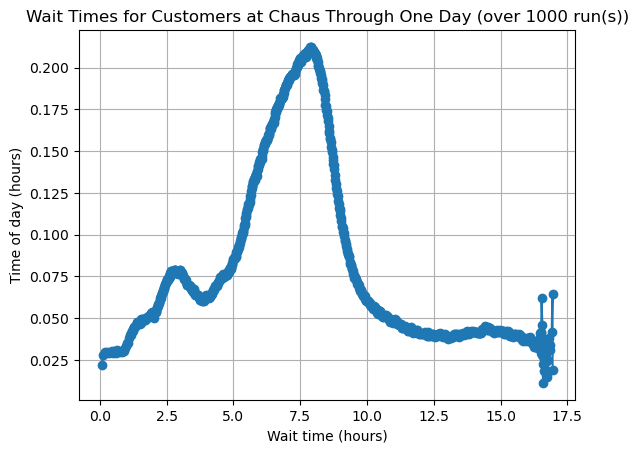

Expected wait of a customer at any point of the day is 0.08679703376405838 hours.


In [391]:
import simpy
import numpy as np
from scipy.stats import norm
from scipy import stats

def antithetic_drink(rate):
    """
    Generates drink service times according to paramter "rate" such that 
    we pair the random variables antithetically. We do this to reduce variance.
    """
    U_lst = []
    for i in range(2000):
        U = np.random.uniform(0, 1)
        anti_U = 1 - U
        drink_service_time1 = -np.log(U) / rate
        drink_service_time2 = -np.log(anti_U) / rate
        U_lst.append(drink_service_time1)
        U_lst.append(drink_service_time2)
    return U_lst
    

def run():
    """
    Runs one simulation of a day at Chaüs.
    
    Returns a list of waiting times, where each entry i is how long customer i
    has spent in the coffee shop. Also returns a list of times, representing how far
    along the day it is from 0 hr to 17 hr (representing 7 am open and 12 am close).
    """

    # setting up simulation environment and the queues
    env = simpy.Environment()
    order_queue = simpy.Resource(env) #, capacity=1)
    drink_queue = simpy.Resource(env) #, capacity=1)

    # to store our results
    wait_time, time_lst = [], []
    
    #generating our antithetic variables
    U_order = antithetic_drink(77)
    U_drink_slow = antithetic_drink(70)
    U_drink_fast = antithetic_drink(150)

    def customer(env, name, order_queue, drink_queue, order_mu, drink_mu_slow, drink_mu_fast):
        """
        Models two M/M/1 queues in tandem. The first queue is for a customer 
        to order their drink. The second queue is for a customer to wait for their drink.
        
        We add the final exit time, along with the current time in the day, to our lists.
        """

        # Customer arrives and joins the first queue
        arrival_time = env.now    

        # customer is in cashier queue
        with order_queue.request() as request:
            yield request
            order_enter_time = env.now
            order_service_time = U_order.pop()
            yield env.timeout(order_service_time)
            order_exit_time = env.now
        
        # if customer orders a drink
        if np.random.uniform(0, 1) <= 0.95:
            # customer is in drink queue
            with drink_queue.request() as request:
                yield request
                drink_enter_time = env.now

                # generating service times for drinks depending on type of drink (slow/fast)
                speed = np.random.uniform(0, 1)
                if speed <= 0.50: 
                    #print(customer_counter)
                    drink_service_time = U_drink_slow.pop()
                else:
                    drink_service_time = U_drink_fast.pop()
                yield env.timeout(drink_service_time)
                drink_exit_time = env.now
            # time customer spent in the system (both queues)
            system_time = drink_exit_time - arrival_time
            wait_time.append(system_time)
            time_lst.append(drink_exit_time)
        
        # if customer doesn't order a drink
        else:
            system_time = order_exit_time - arrival_time
            wait_time.append(system_time)
            time_lst.append(order_exit_time)

    def customer_arrival_process(env, order_queue, drink_queue):
        """
        Makes sure customers arrive according to a non-homogenous poisson process defined in
        gen_rate(time) function. With correct arrival times, we can run the tandem queues
        above. 
        """
        customer_num = 0
        while True:
            interarrival_time = np.random.exponential(1 / gen_rate(env.now))
            yield env.timeout(interarrival_time)
            env.process(customer(env, customer_num, order_queue, drink_queue, 80, 70, 150)) #slow, fast
            customer_num += 1

    # Run the simulation for 17 hours (one work day)
    env.process(customer_arrival_process(env, order_queue, drink_queue))
    env.run(until = 17) 
    return wait_time, time_lst


def run_plot(paths):
    """
    Runs the simulation "paths" number of times and creates a plot 
    looking at the average wait time of a customer throughout the day.
    """
    # Lists to store results for each run
    big_wait_times = []
    big_time_lst = []

    # Run the simulation multiple times
    for path in range(paths):

        # resetting lists, running one simulation, and adding results
        wait_time, time_lst = [], [] 
        wait_times, time_lsts = run()
        
        big_wait_times.append(wait_times)
        big_time_lst.append(time_lsts)

    # Find the maximum length among all runs
    max_len = max(len(lst) for lst in big_wait_times)

    # need to filter results (make them equal in length) to be able to take the mean ignoring "NaN" values
    filtered_wait = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in big_wait_times]
    filtered_times = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in big_time_lst]

    # Calculate the mean, ignoring "NaN" values
    avg_wait = np.nanmean(filtered_wait, axis=0)
    avg_times = np.nanmean(filtered_times, axis=0)

    # Plot the average wait time against the average exit time
    plt.plot(avg_times, avg_wait, marker = 'o')
    plt.xlabel("Wait time (hours)")
    plt.ylabel("Time of day (hours)")
    plt.title(f"Wait Times for Customers at Chaus Through One Day (over {path + 1} run(s))")
    plt.grid(True)
    plt.show()
    return avg_wait, avg_times


#Calculates the MSE using bootstrapping
def bootstrap(n):
    """
    Calculates the mean square error (MSE) through the use
    of the bootstrap method by running n trials.
    """
    
    actual = []
    for path in range(n):
        result, _ =  run()
        actual.append(np.mean(result))
    
    #bootstrap method:
    bootstrap = []
    for path in range(n):
        sample = []
        
        #getting samples without replacement
        for samp in range(n):
            rand = np.random.randint(0, n-1)
            sample.append(actual[rand])
            
        #adding mean of these samples to list
        bootstrap.append(np.mean(sample)) 

    #calculating MSE 
    bootstrap_var = np.var(bootstrap)
    bias = np.mean(bootstrap) - np.mean(actual)
    mse = bootstrap_var - (bias ** 2)
    return mse


def confidence_interval(n):
    """
    Calculates a 95% confidence interval for our results over n trials.
    """
    res = []
    for path in range(n):
        result, _ = run()
        res.append(np.mean(result)) 
    
    # getting mean of average wait time of one day across n trials
    mean = np.mean(res) 
    sem = stats.sem(res) # standard error of mean
    confidence_level = 0.95

    # creating confidence interval
    error = sem * stats.t.ppf((1 + confidence_level) / 2, len(res) - 1) 
    CI = (mean - error, mean + error)
    
    return CI


#running results of simulation:
res = []
# getting mean of average wait time of one day across 1000 trials
for path in range(100):
    result, _ = run()
    res.append(np.mean(result)) 
mean_wait1000 = np.mean(res) 
print("Variance of 1000 trials " + str(np.var(res)))

run_plot(1000)
print("Expected wait of a customer at any point of the day is " + str(mean_wait1000) + " hours.") 